## Import Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import classification_report, accuracy_score, confusion_matrix , roc_curve, auc ,precision_score, recall_score, f1_score

# Utility
import random

## Loading the Dataset

In [2]:
data = pd.read_csv(r"spam.csv", encoding='latin-1')
data = data.rename(columns={'v1': 'label', 'v2': 'message'})
data=data[['label','message']]
data.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Preprocessing

In [3]:
# Drop missing values in 'label' or 'message' columns and show how many rows were removed
before_drop = data.shape[0]
data.dropna(subset=['label', 'message'], inplace=True)
after_drop = data.shape[0]
print(f"Dropped {before_drop - after_drop} rows due to missing values.")

# Remove empty messages
before_empty = data.shape[0]
data = data[data['message'].str.strip().astype(bool)]
after_empty = data.shape[0]
print(f"Removed {before_empty - after_empty} empty messages.")

# Encode labels: ham → 0, spam → 1
data['label'] = data['label'].map({'ham': 0, 'spam': 1})


Dropped 0 rows due to missing values.
Removed 0 empty messages.


## Label Distribution Before Balancing

In [4]:
print("Label distribution :")
print(data['label'].replace({0: 'Ham', 1: 'Spam'}).value_counts())
print(f"Unbalanced dataset shape: {data.shape}")

Label distribution :
label
Ham     4825
Spam     747
Name: count, dtype: int64
Unbalanced dataset shape: (5572, 2)


## Balancing the Dataset (Ham vs. Spam)

## Splitting the Data into Training and Testing Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data['message'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 4457, Testing samples: 1115


## Text Vectorization Using TF-IDF

In [6]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

##  Bagging Model with Naive Bayes

In [7]:
bagging_nb = BaggingClassifier(
    estimator=MultinomialNB(),
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)
bagging_nb.fit(X_train_vec, y_train)
y_pred = bagging_nb.predict(X_test_vec)
y_proba = bagging_nb.predict_proba(X_test_vec)[:, 1]
bagging_acc = accuracy_score(y_test, y_pred)

## Boosting Model With Decision Trees

In [8]:
#models
xgboost_model = XGBClassifier( eval_metric='logloss')
xgboost_model.fit(X_train_vec, y_train)
y_pred_xgb = xgboost_model.predict(X_test_vec)
boosting_acc = accuracy_score(y_test, y_pred_xgb)

## Stacking Model with Naive Bayes

In [9]:
# Define base models for stacking
base_models = [
    ('nb', MultinomialNB()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(probability=True, kernel='linear', random_state=42))
]
meta_learner = LogisticRegression()

# Create Stacking model
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    passthrough=False,
    cv=5
)


stacking_model.fit(X_train_vec, y_train)

# Predict with stacking
y_pred_stacking = stacking_model.predict(X_test_vec)
stacking_acc = accuracy_score(y_test, y_pred_stacking)


 ## Bar Chart for Accuracy Comparison

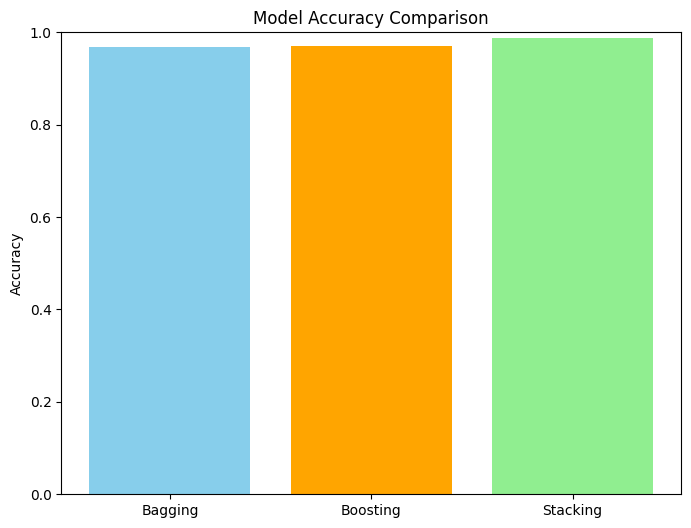

In [10]:
models = ['Bagging', 'Boosting', 'Stacking']
accuracies = [bagging_acc, boosting_acc, stacking_acc]

plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=['skyblue', 'orange', 'lightgreen'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

## ROC Curves for All Models Together

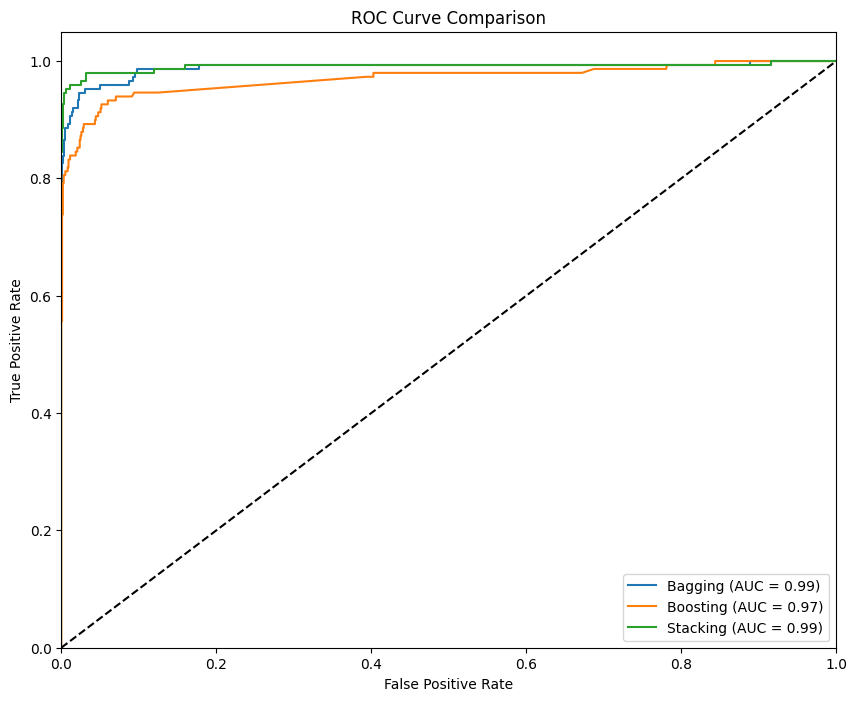

In [11]:
plt.figure(figsize=(10,8))

# Bagging ROC
fpr_bag, tpr_bag, _ = roc_curve(y_test, bagging_nb.predict_proba(X_test_vec)[:,1])
roc_auc_bag = auc(fpr_bag, tpr_bag)
plt.plot(fpr_bag, tpr_bag, label='Bagging (AUC = %0.2f)' % roc_auc_bag)

# Boosting ROC
fpr_boost, tpr_boost, _ = roc_curve(y_test, xgboost_model.predict_proba(X_test_vec)[:,1])
roc_auc_boost = auc(fpr_boost, tpr_boost)
plt.plot(fpr_boost, tpr_boost, label='Boosting (AUC = %0.2f)' % roc_auc_boost)

# Stacking ROC
fpr_stack, tpr_stack, _ = roc_curve(y_test, stacking_model.predict_proba(X_test_vec)[:,1])
roc_auc_stack = auc(fpr_stack, tpr_stack)
plt.plot(fpr_stack, tpr_stack, label='Stacking (AUC = %0.2f)' % roc_auc_stack)

# Random line (no-skill)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix Heatmaps

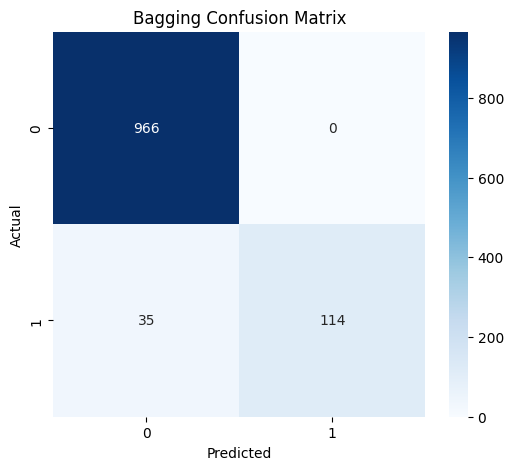

In [12]:
cm = confusion_matrix(y_test, bagging_nb.predict(X_test_vec))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Bagging Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

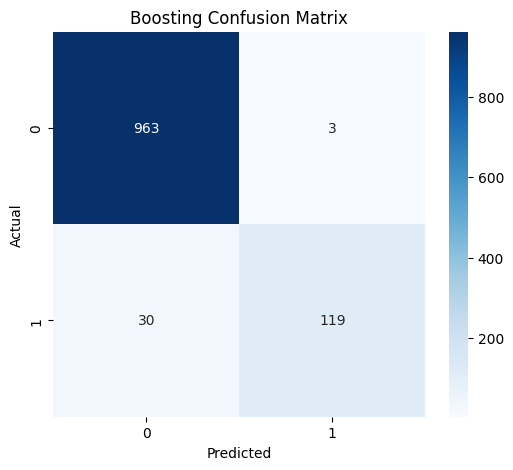

In [13]:
cm = confusion_matrix(y_test, xgboost_model.predict(X_test_vec))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

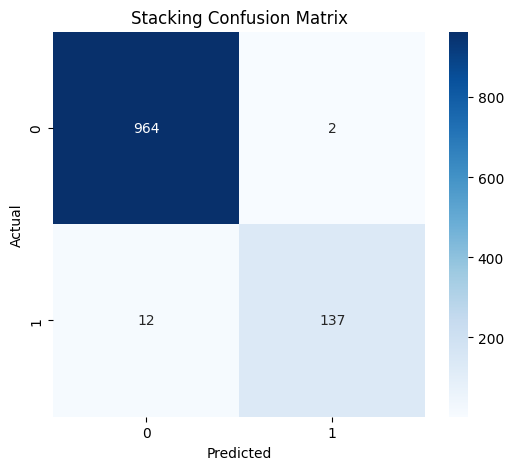

In [14]:
cm = confusion_matrix(y_test, stacking_model.predict(X_test_vec))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Stacking Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Radar Chart

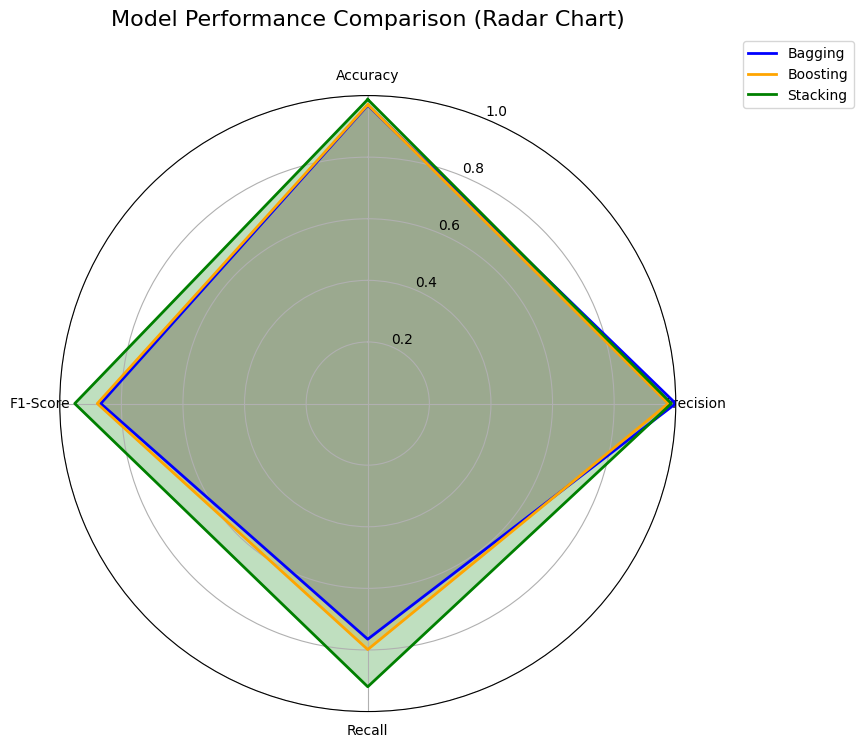

In [15]:
# Bagging
y_pred_bagging = bagging_nb.predict(X_test_vec)
bagging_precision = precision_score(y_test, y_pred_bagging)
bagging_recall = recall_score(y_test, y_pred_bagging)
bagging_f1 = f1_score(y_test, y_pred_bagging)

# Boosting
y_pred_boosting = xgboost_model.predict(X_test_vec)
boosting_precision = precision_score(y_test, y_pred_boosting)
boosting_recall = recall_score(y_test, y_pred_boosting)
boosting_f1 = f1_score(y_test, y_pred_boosting)

# Stacking
y_pred_stacking = stacking_model.predict(X_test_vec)
stacking_precision = precision_score(y_test, y_pred_stacking)
stacking_recall = recall_score(y_test, y_pred_stacking)
stacking_f1 = f1_score(y_test, y_pred_stacking)

# --- prepare data for radar chart ---
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

bagging_stats = [bagging_acc, bagging_precision, bagging_recall, bagging_f1]
boosting_stats = [boosting_acc, boosting_precision, boosting_recall, boosting_f1]
stacking_stats = [stacking_acc, stacking_precision, stacking_recall, stacking_f1]

# Complete the circle
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
bagging_stats += bagging_stats[:1]
boosting_stats += boosting_stats[:1]
stacking_stats += stacking_stats[:1]
angles += angles[:1]

# --- plot the radar chart ---
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

ax.plot(angles, bagging_stats, color='blue', linewidth=2, label='Bagging')
ax.fill(angles, bagging_stats, color='blue', alpha=0.25)

ax.plot(angles, boosting_stats, color='orange', linewidth=2, label='Boosting')
ax.fill(angles, boosting_stats, color='orange', alpha=0.25)

ax.plot(angles, stacking_stats, color='green', linewidth=2, label='Stacking')
ax.fill(angles, stacking_stats, color='green', alpha=0.25)

ax.set_title('Model Performance Comparison (Radar Chart)', size=16, y=1.1)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

## comparison table

In [16]:
results = pd.DataFrame({
    'Model': ['Bagging', 'Boosting', 'Stacking'],
    'Accuracy': [bagging_acc, boosting_acc, stacking_acc]
})

print(results)

      Model  Accuracy
0   Bagging  0.968610
1  Boosting  0.970404
2  Stacking  0.987444


## Predicting with New Sample Texts

In [17]:
#  Predict a random sample message
random_index = random.randint(0, len(data) - 1)
sample_message = data['message'].iloc[random_index]
sample_label = data['label'].iloc[random_index]

# Transform message to vector
sample_vec = vectorizer.transform([sample_message])

# Predict with both models
pred_bagging = bagging_nb.predict(sample_vec)[0]
pred_boosting = xgboost_model.predict(sample_vec)[0]
pred_stack = stacking_model.predict(sample_vec)[0]

# Decode labels
label_map = {0: "HAM", 1: "SPAM"}

print("\n -->Randomly selected message:")
print(f"\"{sample_message}\"")
print(f"\n Actual label: {label_map[sample_label]}")
print(f" Bagging  model prediction: {label_map[pred_bagging]}")
print(f" Boosting model prediction: {label_map[pred_boosting]}")
print(f" Stacking model prediction: {label_map[pred_stack]}")


 -->Randomly selected message:
"tap & spile at seven. * Is that pub on gas st off broad st by canal. Ok?"

 Actual label: HAM
 Bagging  model prediction: HAM
 Boosting model prediction: HAM
 Stacking model prediction: HAM
